In [2]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *
from mitequinox.plot import *

In [3]:
from dask_jobqueue import PBSCluster
#cluster = PBSCluster(cores=12, walltime='04:00:00')
cluster = PBSCluster(cores=6, processes=6,  walltime='06:00:00')
#w = cluster.scale(12*10)
w = cluster.scale(12*1)

In [4]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.135.36.56:42369 Dashboard: http://10.135.36.56:8787/status,Cluster Workers: 12 Cores: 12 Memory: 200.04 GB


___________
# Term 1: time acceleration

### du/dt and dv/dt

In [8]:
E_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/hourly_spectra/'
dij=4
Nt, Ni, Nj = 24*40, 376, 188
dsU = xr.open_zarr(root_data_dir+'zarr/%s.zarr'%('SSU'))
dsU = dsU.isel(time=slice(len(dsU.time)//Nt *Nt)).isel(i_g=slice(0,None,dij), j=slice(0,None,dij))
dsU = dsU.rename({'i_g': 'i'})
dsV = xr.open_zarr(root_data_dir+'zarr/%s.zarr'%('SSV'))
dsV = dsV.isel(time=slice(len(dsV.time)//Nt *Nt)).isel(i=slice(0,None,dij), j_g=slice(0,None,dij))
dsV = dsV.rename({'j_g': 'j'})
dsU

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080, time: 8640)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<chunksize=(8640,), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    iters    (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 3.68e+07 3.68e+07
Data variables:
    SSU      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 1080, 1080), meta=np.ndarray>

In [10]:
#for face in range(13):
for face in [9,10,11,12]:
    
    du_dt = ( dsU['SSU'].isel(face=face).shift(time=-1) - dsU['SSU'].isel(face=face) )/3600
    dv_dt = ( dsV['SSV'].isel(face=face).shift(time=-1) - dsV['SSV'].isel(face=face) )/3600
 
    # store
    du_dt = np.real(du_dt).rename('du_dt')    
    du_dt = du_dt.chunk({'time': 1,'i':1080,'j':1080})
    #print(du_dt)
    %time du_dt.to_dataset().to_zarr(E_dir+'du_dt_f%02d.zarr'% (face), mode='w')

    dv_dt = np.real(dv_dt).rename('dv_dt')    
    dv_dt = dv_dt.chunk({'time': 1,'i':1080,'j':1080})
    #print(dv_dt)
    %time dv_dt.to_dataset().to_zarr(E_dir+'dv_dt_f%02d.zarr'% (face), mode='w')        

    print('face=%d - allready processed'%(face))    

CPU times: user 1min, sys: 3.35 s, total: 1min 3s
Wall time: 2min 13s
CPU times: user 52.8 s, sys: 3.12 s, total: 55.9 s
Wall time: 1min 21s
face=9 - allready processed
CPU times: user 1min 4s, sys: 2.98 s, total: 1min 7s
Wall time: 2min 22s
CPU times: user 55.4 s, sys: 2.82 s, total: 58.2 s
Wall time: 1min 30s
face=10 - allready processed
CPU times: user 57.2 s, sys: 2.86 s, total: 1min
Wall time: 1min 39s
CPU times: user 59.6 s, sys: 3.11 s, total: 1min 2s
Wall time: 1min 48s
face=11 - allready processed
CPU times: user 1min 2s, sys: 3.01 s, total: 1min 5s
Wall time: 2min 3s
CPU times: user 57.5 s, sys: 2.81 s, total: 1min
Wall time: 1min 42s
face=12 - allready processed


# Spectra

In [19]:
E_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/hourly_spectra/'
dij=4

In [20]:
#grd = load_grd(ftype='nc').reset_coords()
grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])
grd_rspec_dij = grd_rspec.isel(i=slice(0,None,dij), j=slice(0,None,dij))

print(grd_rspec_dij)

# !! chunking is coarse for the netcdf grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
Data variables:
    mask     (face, j, i) bool dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>


In [21]:
# spatial strides for decimation
dij=4
overwrite=True
    
for face in range(13):
#for face in [0,1,2,3,4,5,6,7,8,9,10,11,12]:

    Efile = E_dir+'E_uvt_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        # load data
        dsu = xr.open_zarr(E_dir+'du_dt_f%02d.zarr'%(face))
        dsv = xr.open_zarr(E_dir+'dv_dt_f%02d.zarr'%(face))
        dsu = dsu.chunk({'i': 47, 'j':24, 'time':8640})
        dsv = dsv.chunk({'i': 47, 'j':24, 'time':8640})
                       
        ds = xr.merge([dsu, dsv], compat='equals').assign_coords(**grd_rspec_dij.sel(face=face))
        ds['uv_t'] = ds['du_dt'].fillna(0.) + 1j * ds['dv_dt'].fillna(0.)    
        #print(ds)
        #print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

        # spectral computation
        # need to run once to get frequency line
        f, E = get_E(ds['uv_t'].isel(i=2,j=2))
        #
        E = get_E(ds['uv_t'], f=f)        

        # store
        E = E.to_dataset()
        for c in E.coords:
            try:
                del E[c].encoding['chunks']
            except:
                print(c)        
        E = E.chunk({'i': 24*8, 'j':47*4})
        #print(E)
        %time E.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

mask
freq_time
CPU times: user 1min 4s, sys: 2.14 s, total: 1min 6s
Wall time: 2min 1s
--- face 0 done
mask
freq_time
CPU times: user 54 s, sys: 1.58 s, total: 55.5 s
Wall time: 1min 16s
--- face 1 done
mask
freq_time


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 55.9 s, sys: 1.54 s, total: 57.5 s
Wall time: 1min 19s
--- face 2 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


mask
freq_time


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 53.3 s, sys: 1.85 s, total: 55.1 s
Wall time: 1min 15s
--- face 3 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


mask
freq_time


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


CPU times: user 51.8 s, sys: 1.37 s, total: 53.2 s
Wall time: 1min 14s
--- face 4 done


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


mask
freq_time


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 51.4 s, sys: 1.3 s, total: 52.7 s
Wall time: 1min 15s
--- face 5 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


mask
freq_time


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 52.6 s, sys: 1.43 s, total: 54 s
Wall time: 1min 15s
--- face 6 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


mask
freq_time


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 54.2 s, sys: 1.47 s, total: 55.7 s
Wall time: 1min 17s
--- face 7 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


mask
freq_time


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 52.6 s, sys: 1.41 s, total: 54 s
Wall time: 1min 15s
--- face 8 done


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


mask
freq_time


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


CPU times: user 54.1 s, sys: 1.54 s, total: 55.6 s
Wall time: 1min 16s
--- face 9 done


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


mask
freq_time


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


CPU times: user 52.5 s, sys: 1.46 s, total: 54 s
Wall time: 1min 15s
--- face 10 done


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


mask
freq_time


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


CPU times: user 52.4 s, sys: 1.38 s, total: 53.7 s
Wall time: 1min 16s
--- face 11 done


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


mask
freq_time


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


CPU times: user 53 s, sys: 1.39 s, total: 54.4 s
Wall time: 1min 16s
--- face 12 done


## 3. zonal average of rotary spectra

In [22]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 
ice

<xarray.DataArray 'AREA' (face: 13, j: 1080, i: 1080)>
dask.array<getitem, shape=(13, 1080, 1080), dtype=float64, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316

In [23]:
latb = np.arange(-60.,60.,1.)
latc = (latb[:-1]+latb[1:])*.5

def _zhist(x, lat, weights=True):
    # an alternative would be to create xarray dataarrays and use groupby_bins
    # https://github.com/pydata/xarray/issues/1765
    if weights:
        w = x
    else:
        w = np.ones_like(x)
    h, edges = np.histogram(lat, bins=latb, weights=w, density=False)
    return h[None,:]

def zaverage(v):
    dims = ['i','j']
    v = v.fillna(0.)
    lat = v.YC+0.*v
    #
    S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    S = S.assign_coords(latitude=latc).rename('S_SSUV')
    #
    W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    W = W.assign_coords(latitude=latc).rename('W_SSUV')    
    return xr.merge([S, W], compat='identical')

In [24]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ds = xr.concat([xr.open_zarr(E_dir+'E_uvt_f%02d.zarr'%(face))
              for face in F], dim='face', compat='identical')
print(ds)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 1080, j: 1080)
Coordinates:
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    mask       (face, j, i) bool dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
Data variables:
    uv_t       (face, j, i, freq_time) float64 dask.array<chunksize=(1, 188, 192, 1440), meta=np.ndarray>


In [25]:
v = 'uvt'
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
F = [11]

In [47]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]

for face in F:
    lds = ds.isel(face=face).chunk({'i': None, 'j': None,'freq_time':1})
    lice = ice.isel(face=face)
    E = lds.uv_t.isel(i=slice(1,-1),j=slice(1,-1)).where(lds.Depth>2000., drop=False).where(lice>0) # filter out shallow depths
    Eds = zaverage(E).chunk({'freq_time':None})
    Efile = E_dir+'%s_f%02d_zav.zarr'%(v, face)
    Eds.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

--- face 0 done
--- face 1 done
--- face 2 done
--- face 3 done
--- face 4 done
--- face 5 done
--- face 6 done
--- face 7 done
--- face 8 done
--- face 9 done
--- face 10 done
--- face 12 done


In [27]:
F = [11]

for face in F:
    lds = ds.isel(face=face).chunk({'i': None, 'j': None,'freq_time':1})
    lice = ice.isel(face=face)
    E = lds.uv_t.isel(i=slice(1,-1),j=slice(1,-1)).where((lds.Depth>2000.) & (lds.j!=40), drop=False).where(lice>0)  # filter out shallow depths
    Eds = zaverage(E).chunk({'freq_time':None})
    Efile = E_dir+'%s_f%02d_zav.zarr'%(v, face)
    Eds.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

--- face 11 done


In [18]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ds_zav = xr.concat([xr.open_zarr(E_dir+'%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
print(ds_zav)

<xarray.Dataset>
Dimensions:    (freq_time: 1440, latitude: 119)
Coordinates:
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
Data variables:
    S_SSUV     (freq_time, latitude) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>
    W_SSUV     (freq_time, latitude) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>


In [19]:
E_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_grad_Eta')
print(E_zav)

<xarray.DataArray 'E_grad_Eta' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98


In [48]:
v = 'uvt'
ds_zav = xr.concat([xr.open_zarr(E_dir+'%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_geo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_uvt')
print(E_geo_zav)

<xarray.DataArray 'E_uvt' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98


In [49]:
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_geo_zav.latitude))
f_cpd = f*86400/2./np.pi

Text(0.5, 0, 'Frequency (cpd)')

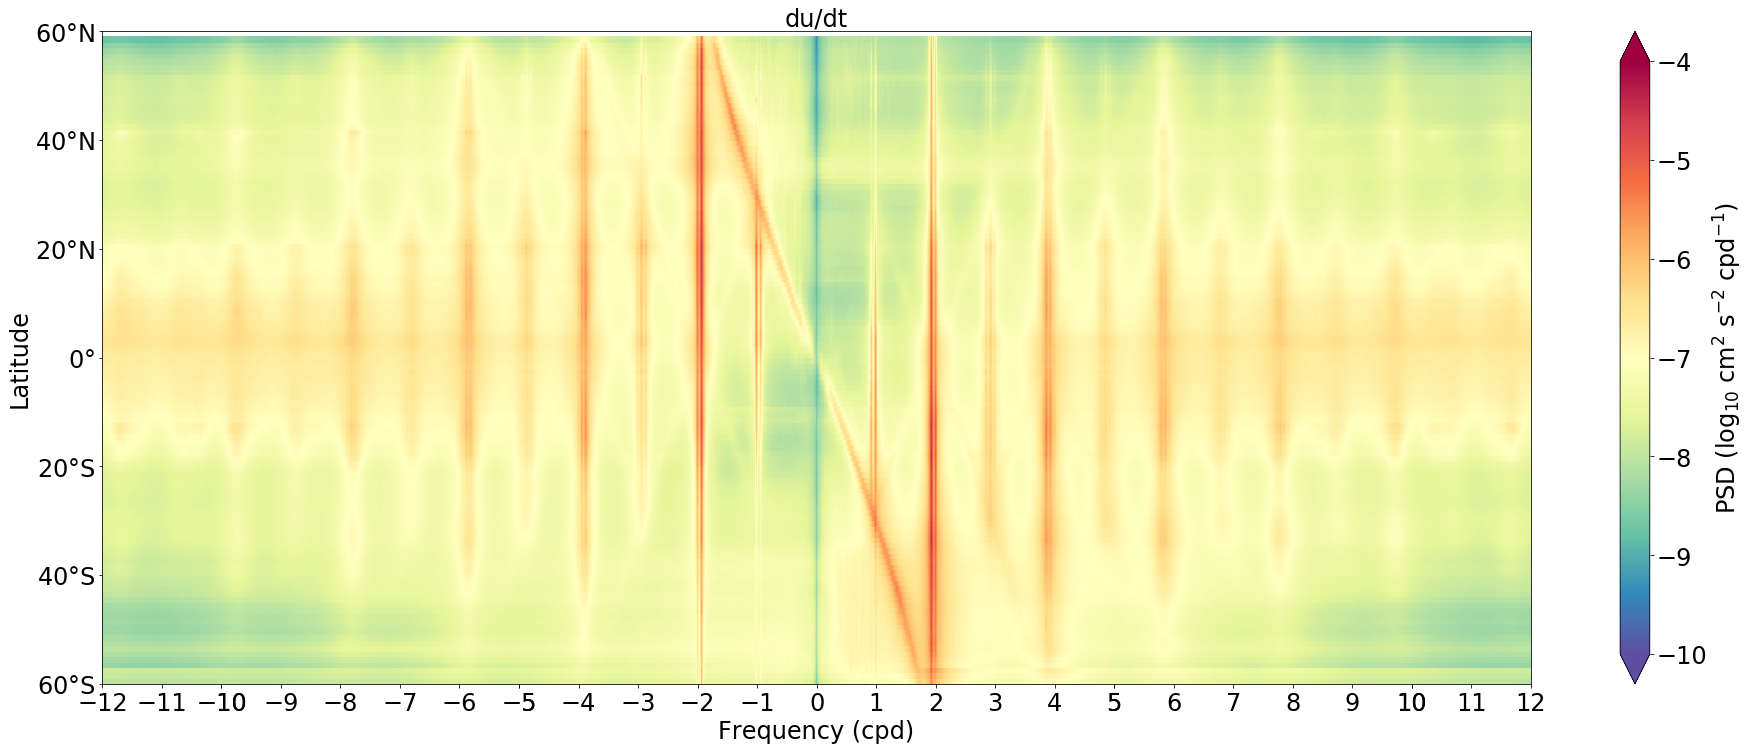

In [50]:
font_size = 24
fig, ax = plt.subplots(figsize=(32,12))

ax = plt.subplot(111)
cax=np.log10(E_geo_zav*86400/6).plot(vmin=-10, vmax=-4, x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)
#cax=np.log10(E_geo_zav*86400/6).plot( x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)

cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (log$_{10}$ cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-12.,-11.,-10.,-9.,-8.,-7.,-6.,-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12])
ax.set_xlim(-12., 12.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_title('du/dt',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)


In [21]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home/uz/yux/.conda/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=